<img src="https://www.anped.org.br/sites/default/files/images/ufcg-lateral.png" width="780" height="240" align="center"/>

## Centro de Engenharia Elétrica e Informática
## Departamento de Engenharia Elétrica
## Disciplina: Int. ao Processamento de Imagem Digital e Visão Computacional
## Professora: Luciana Veloso
## Aluno(a): Fabio Victor Galdino Nascimento

# Experimento 08: Ajuste Fino

In [30]:
import os                                             # Operational System para manipulação de arquivos.
import cv2                                            # OpenCV para manipulação de imagens.
import random
import numpy as np                                    # Numpy para manipulação de matrizes e arrays.
import matplotlib.pyplot as plt                       # Pyplot para plotagem de gráficos e imagens.
from sklearn.metrics import confusion_matrix          # Scikit-Learn para plotar a matriz de confusão

from tensorflow.keras import layers                   # Módulo de camadas do Keras
from tensorflow.keras import callbacks                # Módulo de callbacks do Keras
from tensorflow.keras import optimizers               # Módulo de otimizadores do Keras
from tensorflow.keras.models import load_model        # Função para carregar um modelo salvo
from tensorflow.keras.applications import VGG16       # Classe de modelos sequenciais para construir as redes neurais.

from google_drive_downloader import GoogleDriveDownloader as gdd

# ImageDataGenerator, utilizado para carregar imagens em tempo de execução
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. Dados do Experimento

* Vamos utilizar o banco de dados Cats vs Dogs, que foi utilizado no Desafio Prático;

* Cada instância do banco de dados corresponde a uma imagem rotulada de um Cachorro ou um Gato;

* As imagens do banco de dados são coloridas e foram redimensionadas para 150x150;

* Imagens de Cachorro têm rótulo 0 e as de Gato têm rótulo 1;

* A versão que estamos usando tem 3000 imagens, 2000 para treino, 500 para validação e 500 para teste;

* Todas as partições da base de dados são balanceadas;

* Os dados do experimento podem ser baixados no [link](https://drive.google.com/file/d/1iYleZOPahuxO-u0TGNPiuxvKZt0tQgqe/view?usp=sharing).

In [31]:
gdd.download_file_from_google_drive(file_id = '1iYleZOPahuxO-u0TGNPiuxvKZt0tQgqe',
                                    dest_path = './dados_exp_8.zip',
                                    unzip = True)

gdd.download_file_from_google_drive(file_id = '16OmmOh8abTNv3xxFVpH3s77D90uO041g',
                                    dest_path = './model.h5',
                                    unzip = False)

### 1.1. Carregando dados em tempo Real

O Keras disponibiliza um objeto ImageDataGenerator para o carregamento de dados em tempo real durante o treinamento de modelos. São necessárias duas etapas para configurar o objeto:

1. Definição das transformações realizadas sobre os dados, ao instanciar o ImageDataGenerator propriamente dito:
    * Isso pode ser feito a partir de **datagen = ImageDataGenerator( rescale = 1./255 )**
    * Nesse exemplo o único parâmetro setado é o rescale, que define uma constante para normalizar as imagens carregadas.
    * Outras transformações podem ser especificadas utilizando outros parâmetros;
2. Definição do método de carregamento:
    * Os dados podem ser carregados com base em uma estrutura de diretórios ou a partir de um dataframe;
    * Vamos utilizar o método **flow_from_directory** para carregar os dados com base na estrutura de dados montada;
    * A chamada do método se faz a partir de **generator = datagen.flow_from_directory( data_dir, target_size, batch_size, class_mode)**
        * generator é um objeto de fornece exemplos continuamente a não ser que seja explicitamente encerrado ( while(True) );
        * data_dir é o diretório raiz dos dados, dentro dessa pasta os exemplos devem estar divididos por classe em pastas distintas;
        * target_size é uma tupla que especifica o tamanho das imagens carregadas;
        * class_mode define como os gabaritos são carregados, se **"binary"** carrega os gabaritos como inteiros 0 ou 1, se **"categorical"** carrega gabaritos categóricas conforme usadas no Exp. 7, se **None** não carrega gabaritos;

In [32]:
val_datagen   = ImageDataGenerator( rescale = 1./255 )
val_generator = val_datagen.flow_from_directory( os.path.join(".", "data", "val"), target_size = (150, 150),
                                                 batch_size  = 20, class_mode  = "binary")

# Atributo do generator que fornece o número de amostras detectadas
val_samples = val_generator.samples 
print(val_samples, "amostras detectadas")

# Atributo do generator que fornece o mapeamento de classe para índice 
# Repare que os índices são definidos pelo generator com base nos diretórios de arquivos em ordem alfabética
class_to_idx_dict = val_generator.class_indices
print( "Mapeamento Classes -> Índices:", class_to_idx_dict )

# Construção de um novo dicionário que inverte o mapeamento
idx_to_class_dict = { v: k for k, v in class_to_idx_dict.items() }
print( "Mapeamento Índices -> Classes:", idx_to_class_dict )

Found 1000 images belonging to 2 classes.
1000 amostras detectadas
Mapeamento Classes -> Índices: {'Cachorro': 0, 'Gato': 1}
Mapeamento Índices -> Classes: {0: 'Cachorro', 1: 'Gato'}


### 1.2. Aumento de Dados

Outras transformações possíveis no ImageDataGenerator viabilizam o aumento de dados. Nesse sentido, é possível definir transformações aleatórias que são realizadas conforme os dados são carregados para simular um banco de dados maior.

* Exemplos de transformações aleatórias são:
    * rotation_range valor que define o valor máximo (em graus) das rotações aleatórias realizadas;
    * width_shift_range valor (em fração) que determina o valor máximo de uma translação horizontal realizada com base na largura da imagem;
    * height_shift_range valor (em fração) que determina o valor máximo de uma translação vertical realizada com base na altura da imagem;
    * zoom_range valor (em fração) que determina o maior zoom aleatório realizado na imagem;
    * shear_range valor (em fração) que determina a maior deformação aleatória realizada na imagem;
    * horizontal_flip booleano que determina se reflexões horizontais devem ser aplicadas aleatoriamente na imagem;
    * vertical_flip booleano que determina se reflexões verticais devem ser aplicadas aleatoriamente na imagem;
    * fill_mode modo de preenchimento de buracos provocados pelas transformações realizadas:
        * 'constant': preenche os buracos com um valor constante que pode ser fornecido pelo parâmetro **cval**;
        * 'nearest': preenche os buracos com a repetição dos elementos mais próximos das suas bordas;
        * 'reflect': preenche os buracos com a reflexão dos elementos mais próximos das suas bordas;
        * 'wrap': preenche os buracos considerando a imagem como um sinal periódico;
        
* Mais informações em https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [33]:
train_datagen = ImageDataGenerator( rescale = 1./255,           #
                                    rotation_range = 45,        # Rotação aleatória de até 40°
                                    width_shift_range = 0.2,    # Translação horizontal de até 20% da largura
                                    height_shift_range = 0.2,   # Translação vertical de até 20% da altura
                                    zoom_range = 0.2,           # Zoom aleatório de até 20%
                                    shear_range=0.2,            # Deformação de 20%
                                    horizontal_flip = True,     # Espelhamento horizontal aleatório
                                    vertical_flip = False,      # Espelhamento vertical aleatório
                                    fill_mode = "nearest")      # Preenchimentod e buracos pelo pixel mais próximo

train_generator = train_datagen.flow_from_directory( os.path.join(".", "data", "train"), target_size = (150, 150),
                                                     batch_size  = 20, class_mode  = "binary")

# Atributo do generator que fornece o número de amostras detectadas
train_samples = train_generator.samples 
print(train_samples)

Found 2000 images belonging to 2 classes.
2000


**a. A utilização de aumento de dados substitui ou expande o banco de dados? Justifique.**

<font color = 'red'>

**Comentário:**

Expande! O ImageDataGenerator faz com que uma mesma imagem possa ser aplicada translação, rotação, mudança de tamanho, entre outros. Dessa forma, geramos diversas novas imagens, aumentando o banco de dados.
    
</font>

## 2. Carregando o Modelo

* Dessa vez vamos carregar o modelo treinado na parte 1 do experimento:
    * **model = load_model(path)**
    * Esse comando carrega todas as informações do modelo treinado, incluindo arquitetura e os pesos

In [34]:
model = load_model("model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### 2.2. Acessando Camadas

* No Keras podemos acessar as camadas do modelo individualmente através do atributo **layers** de um modelo, que retorna uma lista das suas camadas. É possível verificar e alterar alguns dos atribudos das camadas, a exemplo de:

    * **layer.input_shape** dimensões do tensor de entrada, "None" indica uma dimensão coringa, que aceita qualquer tamanho;
    * **layer.output_shape** dimensões do tensor de saída, "None" indica uma dimensão coringa, que aceita qualquer tamanho;
    * **layer.trainable** variável booleana que indica se os pesos da camada são treináveis ou não;
    * **layer.name** nome da camada, pode ser modificado a partir do argumento optativo "name" nas funções de todas as camadas;


* Mais informações sobre as camadas podem ser vistas em: https://keras.io/api/layers/

In [35]:
for layer in model.layers:
    status = "Treinável" if layer.trainable else "Congelada"
    print("Camada '{}' - Status: {} - Entrada: {} - Saída: {}".format( layer.name,
                                                                       layer.trainable, 
                                                                       layer.input_shape, 
                                                                       layer.output_shape ))

Camada 'vgg16' - Status: True - Entrada: (None, 150, 150, 3) - Saída: (None, 4, 4, 512)
Camada 'flatten' - Status: True - Entrada: (None, 4, 4, 512) - Saída: (None, 8192)
Camada 'dense' - Status: True - Entrada: (None, 8192) - Saída: (None, 256)
Camada 'dense_1' - Status: True - Entrada: (None, 256) - Saída: (None, 1)


Também é possível acessar camadas através da função **get_layer**, que retorna uma camada a partir de uma referência ao seu nome.

* Observe a base convolucional da VGG16 é vista como uma única camada, que do ponto de vista do modelo produzida é uma camada treinável.
* Contudo, quando verificamos as suas camadas internas é possível ver que todas as elas estão congeladas.

In [36]:
conv_base = model.get_layer("vgg16")
for layer in conv_base.layers:
    status = "Treinável" if layer.trainable else "Congelada"
    print("Camada '{}' - Status: {} - Entrada: {} - Saída: {}".format( layer.name,
                                                                       status, 
                                                                       layer.input_shape, 
                                                                       layer.output_shape ))

Camada 'input_2' - Status: Treinável - Entrada: [(None, 150, 150, 3)] - Saída: [(None, 150, 150, 3)]
Camada 'block1_conv1' - Status: Congelada - Entrada: (None, 150, 150, 3) - Saída: (None, 150, 150, 64)
Camada 'block1_conv2' - Status: Congelada - Entrada: (None, 150, 150, 64) - Saída: (None, 150, 150, 64)
Camada 'block1_pool' - Status: Congelada - Entrada: (None, 150, 150, 64) - Saída: (None, 75, 75, 64)
Camada 'block2_conv1' - Status: Congelada - Entrada: (None, 75, 75, 64) - Saída: (None, 75, 75, 128)
Camada 'block2_conv2' - Status: Congelada - Entrada: (None, 75, 75, 128) - Saída: (None, 75, 75, 128)
Camada 'block2_pool' - Status: Congelada - Entrada: (None, 75, 75, 128) - Saída: (None, 37, 37, 128)
Camada 'block3_conv1' - Status: Congelada - Entrada: (None, 37, 37, 128) - Saída: (None, 37, 37, 256)
Camada 'block3_conv2' - Status: Congelada - Entrada: (None, 37, 37, 256) - Saída: (None, 37, 37, 256)
Camada 'block3_conv3' - Status: Congelada - Entrada: (None, 37, 37, 256) - Saída: (

**a. Quais das camadas acima podem ser consideradas mais especializadas e quais podem ser consideradas mais generalistas? Justifique.**

<font color = 'red'>

**Comentário:**

Podemos observar que as camadas congeladas são as mais generalistas, enquanto as outras tem um papel mais decisivo, como no caso a Dense que é a rede neural totalmente conectada.
    
</font>

**b. Com base na resposta acima, quais das camadas acima são mais valiosas para o modelo que treinamos? Justifique.**

* Lembre-se que a VGG16 foi pré-treinada em outro banco de dados para a classificação de objetos em até 1000 classes distintas.

<font color = 'red'>

**Comentário:**

Nesse caso, são as camadas congeladas. Visto que, nela será realizada as filtragens.
    
</font>

### 2.3. Descongelando Camadas

No Keras, camadas de uma rede podem ter seus pesos congelados, fazendo com que eles não sejam modificados durante o treinamento. 

* Para fazer isso, basta selecionar uma camada e modificar seu atributo **trainable** para False.
* Em contrapartida, para descongelar uma camada basta alterar o mesmo atributo para True.

**c. Analise o código abaixo e comente o que é realizado em cada linha.**

* Quantas camadas são descongeladas?
* Quais camadas são descongeladas?

In [37]:
model.trainable = True #Descongela a base do modelo
conv_base = model.get_layer("vgg16") #Carrega o número de camadas de vgg16

set_trainable = False #Cria a uma variável que recebe False
for layer in conv_base.layers: #Loop de acordo com o número de camadas 
    if layer.name == "block5_conv2":#A proxima linha executará quando chegar na camada desejada 
        set_trainable = True #Variável mudará para True
    layer.trainable = set_trainable #Determina se a camada será treinavél de acordo com set_trainable 

<font color = 'red'>

**Comentário:**

Foram três, a block5_conv2 em diante.
    
</font>

**d. O ajuste fino dos modelos funciona melhor com pequenos valores para a taxa de aprendizagem.**

* A afirmação acima é verdadeira? Justifique.

<font color = 'red'>

**Comentário:**

Sim, está verdadeira! Como estamos treinando um modelo muito maior do que na primeira rodada de treinamento, em um conjunto de dados que normalmente é muito pequeno. Corre um risco muito grande de overfitting se utilizarmos altos valores para a taxa de aprendizagem.
    
</font>

In [38]:
model.compile(optimizer=optimizers.Adam(lr=1e-5), 
              loss="binary_crossentropy", 
              metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 6,817,281
Non-trainable params: 9,995,072
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## 3. Treinando o Modelo

### 3.1. Callbacks

* Dessa vez utilizaremos uma nova callback do Keras, o ReduceLROnPlateau.
* Essa função modifica a taxa de aprendizagem utilizada durante o treinamento caso a variável monitorada deixe de melhorar por um número pré-definido de epochs.
* reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor, factor, patience, verbose)
    * monitor é a variável que deve ser monitorada pelo callback;
    * factor é a constante que deve ser multiplicada pela taxa de aprendizagem atual caso um ajuste seja realizado;
    * patience é o número de epochs sem melhora que devem ocorrer para que um ajuste na taxa de aprendizagem seja realizado;
    * verbose é o modo de texto, 1 indica para que o Keras avise quando um novo modelo for salvo;
    
    
* Lista de callbacks disponíveis: https://keras.io/api/callbacks/

In [39]:
model_checkpoint = callbacks.ModelCheckpoint("model_ft.h5", monitor = "val_acc", save_best_only = True, verbose = 1)
reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor = "val_acc", factor = 0.75, patience = 3, verbose = 1)

# Repare que ao utilizar mais de 1 callback elas devem ser organizadas em uma lista
callback_list = [model_checkpoint, reduce_lr_on_plateau]

### 3.2. Ajuste dos Pesos

O treinamento é realizado a partir da função **fit**, que recebe dados de treino e de validação além de hiperparâmetros como o número de épocas e o tamanho dos lotes de dados (batchsize). Nesse caso, como estamos utilizando generators, não é preciso fornecer os exemplos e os gabaritos separadamente e nem o batchsize:

* **hist = model.fit( x = None, steps_per_epoch = None, epochs = 1, callbacks = [], validation_data = None, validation_steps = None, verbose = "auto")**
    * x corresponde aos dados de treino, também pode ser um generator;
    * steps_per_epoch corresponde ao número de lotes (batches) que devem ser produzidos com o generator de treino por epoch;
    * epochs corresponde ao número de épocas de treinamento;
    * callbacks corresponde à lista de callbacks utilizada;
    * validation_data corresponde aos dados de validação, também pode ser um generator;
    * validation_steps corresponde ao número de lotes (batches) que devem ser produzidos com o generator de validação por epoch;
    * verbose indica como a função deve reportar os resultados:
        * 0: modo silencioso, nenhum retorno em formato de texto;
        * 1: retorno a cada época e barra de progresso;
        * 2: retorno a cada época sem barra de progresso;
    * hist é um dicionário de retorno com os valores de loss e das métricas computadas para treino e validação;

In [40]:
history = model.fit( train_generator, steps_per_epoch = 100,
                     epochs = 30, callbacks = callback_list, 
                     validation_data = val_generator, validation_steps = 50 )

model.load_weights("model_ft.h5")

history_dict = history.history

Epoch 1/30
100/100 [==============================] - 25s 244ms/step - loss: 0.2806 - acc: 0.8730 - val_loss: 0.2311 - val_acc: 0.9010

Epoch 00001: val_acc improved from -inf to 0.90100, saving model to model_ft.h5
Epoch 2/30
100/100 [==============================] - 24s 241ms/step - loss: 0.2535 - acc: 0.8915 - val_loss: 0.2489 - val_acc: 0.8980

Epoch 00002: val_acc did not improve from 0.90100
Epoch 3/30
100/100 [==============================] - 24s 239ms/step - loss: 0.2694 - acc: 0.8875 - val_loss: 0.2134 - val_acc: 0.9130

Epoch 00003: val_acc improved from 0.90100 to 0.91300, saving model to model_ft.h5
Epoch 4/30
100/100 [==============================] - 24s 241ms/step - loss: 0.2228 - acc: 0.9050 - val_loss: 0.2170 - val_acc: 0.9060

Epoch 00004: val_acc did not improve from 0.91300
Epoch 5/30
100/100 [==============================] - 24s 240ms/step - loss: 0.2399 - acc: 0.8960 - val_loss: 0.2056 - val_acc: 0.9110

Epoch 00005: val_acc did not improve from 0.91300
Epoch 6

### 3.3. Resultados

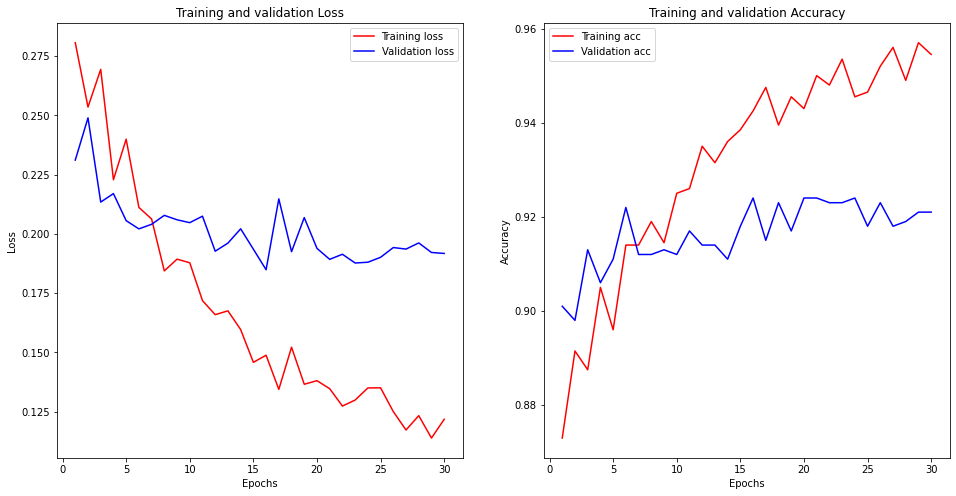

In [46]:
fig, axes = plt.subplots(1, 2, squeeze = False, figsize = (16,8))

# Loss
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

# Epochs
epochs = range(1, len(train_loss_values) + 1)

# Accuracy
train_acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

ax = axes.flat[0]
ax.plot(epochs, train_loss_values, "r", label="Training loss")
ax.plot(epochs, val_loss_values, "b", label="Validation loss")
ax.set_title("Training and validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

ax = axes.flat[1]
ax.plot(epochs, train_acc_values, "r", label="Training acc")
ax.plot(epochs, val_acc_values, "b", label="Validation acc")
ax.set_title("Training and validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()

## 4. Teste do Modelo

### 4.1. Métricas

O teste do modelo pode ser realizado a partir da função **evaluate**, que também suporta generators.

* Observe que dessa vez utilizou-se o parâmetro "shuffle" no flow_from_directory. Isso foi feito para que os exemplos de teste não fossem embaralhados pelo generator e pudessem ser identificados posteriormente.

In [47]:
test_datagen   = ImageDataGenerator( rescale = 1./255 )
test_generator = test_datagen.flow_from_directory( os.path.join(".", "data", "test"), target_size = (150, 150),
                                                   batch_size  = 1, class_mode  = "binary", shuffle = False)

# Atributo do generator que fornece o número de amostras detectadas
test_samples = test_generator.samples

test_loss, test_acc = model.evaluate( test_generator )

print("Test Accuracy:", 100*test_acc, "%")
print("Acertos: {} - Erros: {}".format(round(test_samples * test_acc), 
                                       round(test_samples * (1-test_acc) )))

Found 1000 images belonging to 2 classes.
1000/1000 [==============================] - 22s 22ms/step - loss: 0.1758 - acc: 0.9270
Test Accuracy: 92.69999861717224 %
Acertos: 927 - Erros: 73


**a. Por que o ajuste fino é realizado do final para o começo (i.e. começando pelas últimas camadas e indo em direção às primeiras)? Justifique.**

<font color = 'red'>

**Comentário:**

Porque as últimas camadas são as mais relevantes para o rede.
    
</font>

**b. Experimente descongelar mais camadas da VGG16 e continuar o ajuste fino. O que aconteceu?**

<font color = 'red'>

**Comentário:**

Descongelando da canada block2_conv1 em diante, percebemos que os resultados melhoraram visto que os parâmetros das novas camadas descongeladas ficaram com valores mais específicos. 
    
</font>

### 4.2. Visualização dos Resultados

In [48]:
def show_results(paths, ytest, ypred, labels, num = 25, tipo = "rand"):
    
    if tipo == "acertos":
        fltr_idx = [i for i in range(ytest.shape[0]) if ypred[i] == ytest[i]]
    else:
        fltr_idx = [i for i in range(ytest.shape[0]) if ypred[i] != ytest[i]]
        
    indices = np.random.choice(fltr_idx, min(num, len(fltr_idx)), replace=False)
       
    rows = int(num/5)
    fig, axs = plt.subplots(nrows = rows, ncols = 5, figsize=(20, 5*rows))
    
    for i, idx in enumerate(indices):
        path = os.path.join(".", "data", "test", paths[idx])
        img = cv2.imread(path)[:,:,::-1]
        if ypred[idx] == ytest[idx]:
            axs[i//5][i%5].set_title(labels[ytest[idx]], color = "green", fontsize = 20)
        else:
            axs[i//5][i%5].set_title("Pred: {}\n Gabarito: {}".format(labels[ypred[idx]], 
                                                                      labels[ytest[idx]]), color = "red", fontsize = 20)
        
        axs[i//5][i%5].imshow(img, vmin=0, vmax=255, cmap = "gray")
    return

test_generator.reset()
filenames = test_generator.filenames
labels = test_generator.labels

pred_labels = model.predict(test_generator, verbose=0)
preds = [int(pred[0] > 0.5) for pred in pred_labels]

#### Acertos

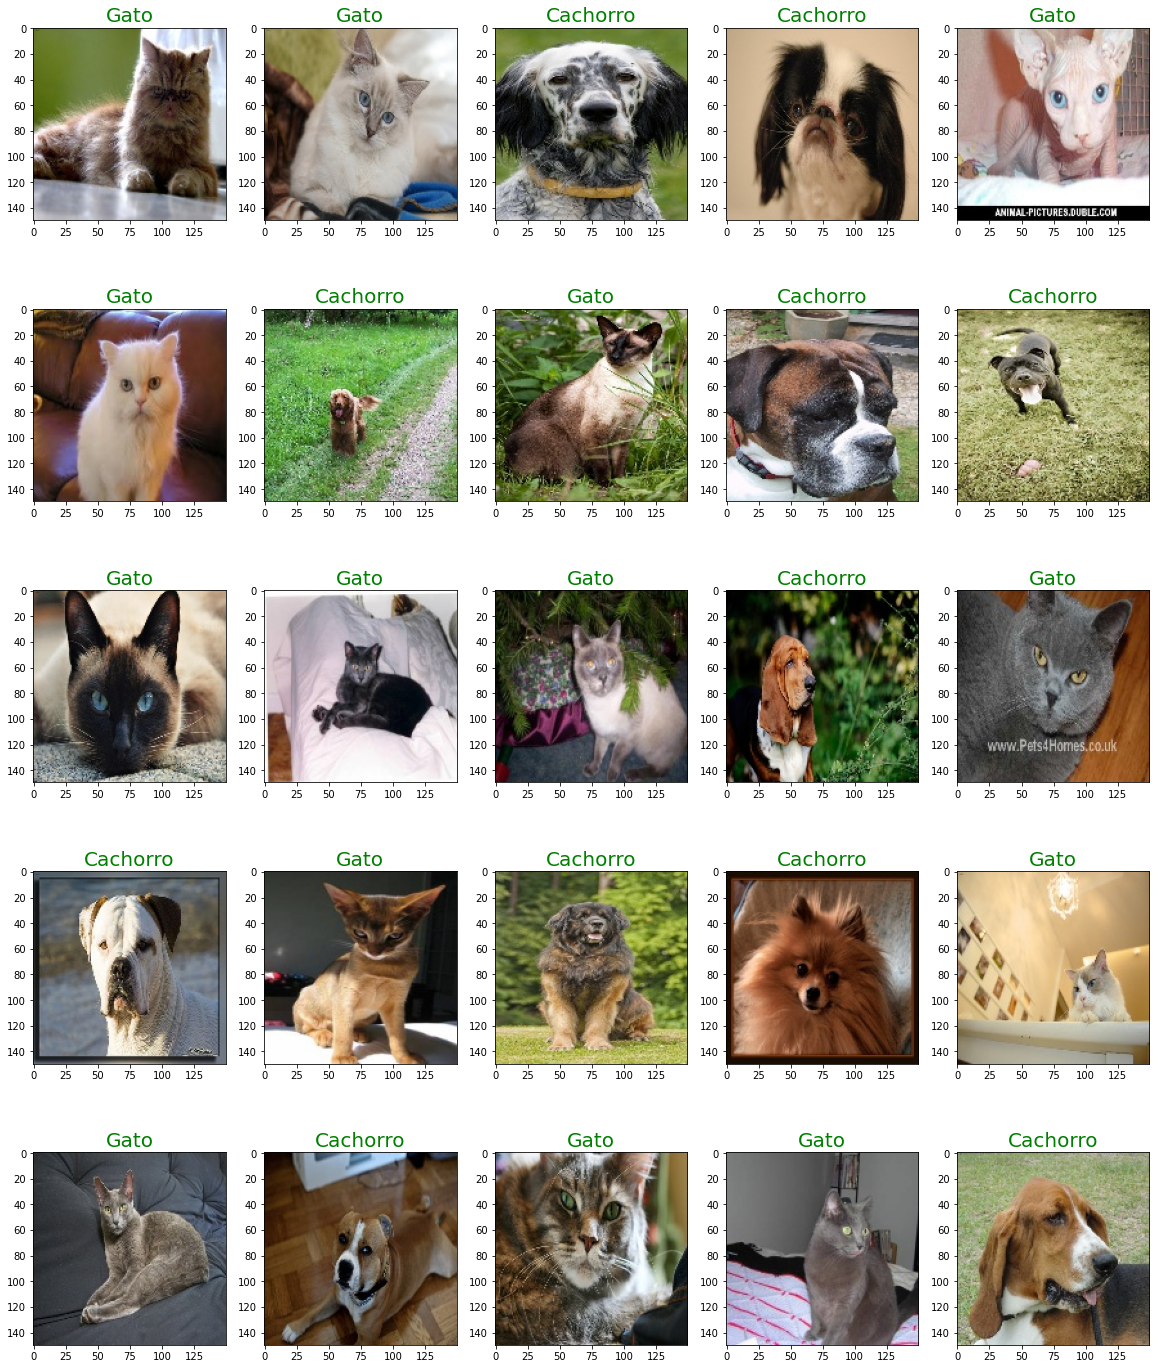

In [49]:
show_results(filenames, labels, preds, idx_to_class_dict, tipo = "acertos")

#### Erros

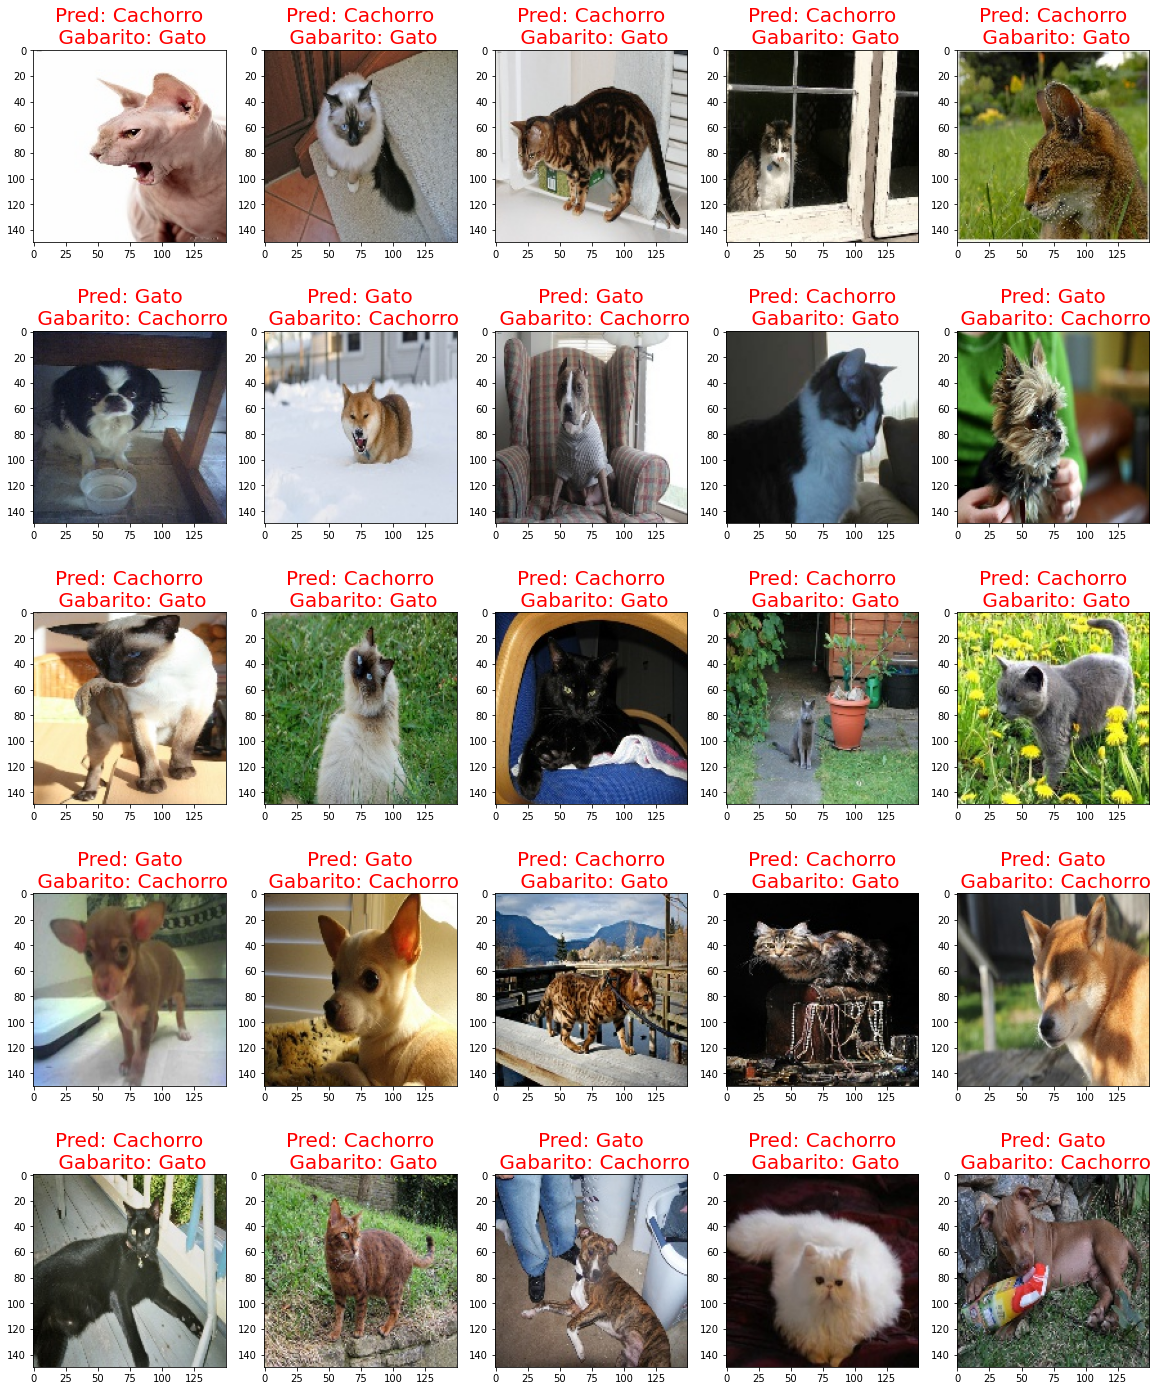

In [50]:
show_results(filenames, labels, preds, idx_to_class_dict, tipo = "erros")